In [60]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def date_parser(x):
    if str.lower(x) == 'unknown':
        return None
    return datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

df = pd.read_csv('../data/fullsample.csv',
                 parse_dates=['BEGIN', 'END'],
                 date_parser=date_parser)


In [3]:
df = df.rename(columns=str.lower)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   jobid      object        
 1   state      object        
 2   begin      datetime64[ns]
 3   end        datetime64[ns]
 4   reqmem     object        
 5   usedmem    object        
 6   reqtime    object        
 7   usedtime   object        
 8   nodes      int64         
 9   cpus       int64         
 10  partition  object        
 11  exitcode   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 677.1+ MB


In [4]:
# add date and hour of day column
df['date_end'] = df['end'].dt.date
df['year_end'] = df['end'].dt.year
df['week_end'] = df['end'].dt.week
df['month_end'] = df['end'].dt.month
df['hour_of_day_end'] = df['end'].dt.hour

df.info()

<ipython-input-4-af46d9c6392f>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_end'] = df['end'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   jobid            object        
 1   state            object        
 2   begin            datetime64[ns]
 3   end              datetime64[ns]
 4   reqmem           object        
 5   usedmem          object        
 6   reqtime          object        
 7   usedtime         object        
 8   nodes            int64         
 9   cpus             int64         
 10  partition        object        
 11  exitcode         object        
 12  date_end         object        
 13  year_end         float64       
 14  week_end         float64       
 15  month_end        float64       
 16  hour_of_day_end  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(9)
memory usage: 959.2+ MB


In [5]:
# count values per day per hour

jobs_ended = df\
    .value_counts(subset=['date_end',
                          'year_end',
                          'month_end',
                          'week_end',
                          'hour_of_day_end',
                          'exitcode'])\
    .reset_index()\
    .set_index(['date_end', 'year_end', 'month_end', 'week_end', 'hour_of_day_end'])\
    .rename(columns={0:'jobs_ended_per_hour'})


In [6]:
def draw_plot(series=None, kind='line', title='', xlabel='', ylabel=''):
    matplotlib.pyplot.ticklabel_format(axis='y', style='plain', useLocale=True)
    series.plot(kind=kind,
                title=title,
                xlabel=xlabel,
                ylabel=ylabel)

In [7]:
def print_outliers_msg(series=None, label='', size=5):
    top_5 = series.nlargest(n=size).sort_values()
    bottom_5 = series.nsmallest(n=size).sort_values()

    print(f'The top 5 busiest {label} were: {top_5.index.values.astype(int)}')
    print(f'The least busiest {label} were: {bottom_5.index.values.astype(int)}')

In [8]:
def group_data(dataframe=None, groupby='', agg='', agg_func='sum'):
    return dataframe\
        .groupby(groupby)[agg]\
        .agg(agg_func)

In [9]:
def group_data_v2(dataframe=None, groupby='', agg='', agg_func='sum'):
    return dataframe\
        .groupby(['exitcode', groupby])[agg]\
        .agg(agg_func)\
        .unstack()\
        .dropna()\
        .transpose()


The top 5 busiest hours of the day were: [11 18 15 16 17]
The least busiest hours of the day were: [6 5 4 3 7]


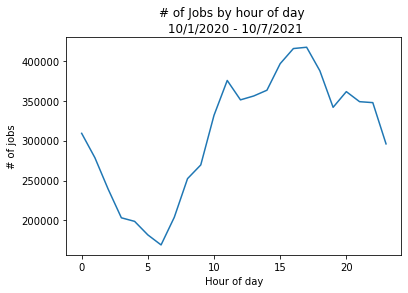

In [10]:
tmp_series = group_data(dataframe=jobs_ended, groupby='hour_of_day_end', agg='jobs_ended_per_hour')

draw_plot(series=tmp_series,
          title='# of Jobs by hour of day \n 10/1/2020 - 10/7/2021',
          xlabel='Hour of day',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='hours of the day')


The top 5 busiest weeks were: [43 31 35 37 32]
The least busiest weeks were: [21 20 52  6 45]


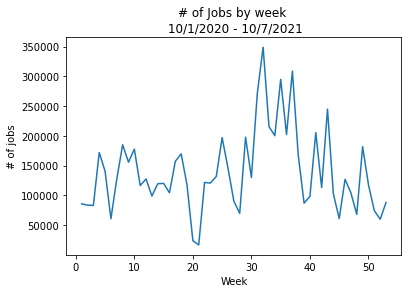

In [11]:
tmp_series = group_data(dataframe=jobs_ended, groupby='week_end', agg='jobs_ended_per_hour')
draw_plot(series=tmp_series,
          title='# of Jobs by week \n 10/1/2020 - 10/7/2021',
          xlabel='Week',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='weeks')


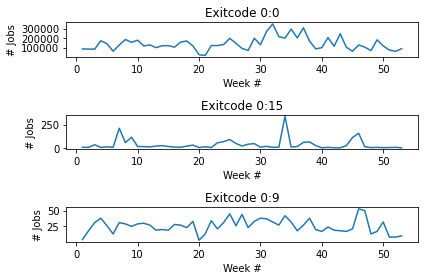

In [25]:
# trying to chart the different status types...

fig, axes = plt.subplots(nrows=3, ncols=1)

tmp_series = group_data_v2(dataframe=jobs_ended, groupby='week_end', agg='jobs_ended_per_hour')

i = 0
for column in tmp_series.columns.to_list():
    axes[i].set_title(f'Exitcode {column}')
    axes[i].set_ylabel('# Jobs')
    axes[i].set_xlabel('Week #')
    axes[i].plot(tmp_series[column])
    i+=1

plt.tight_layout()

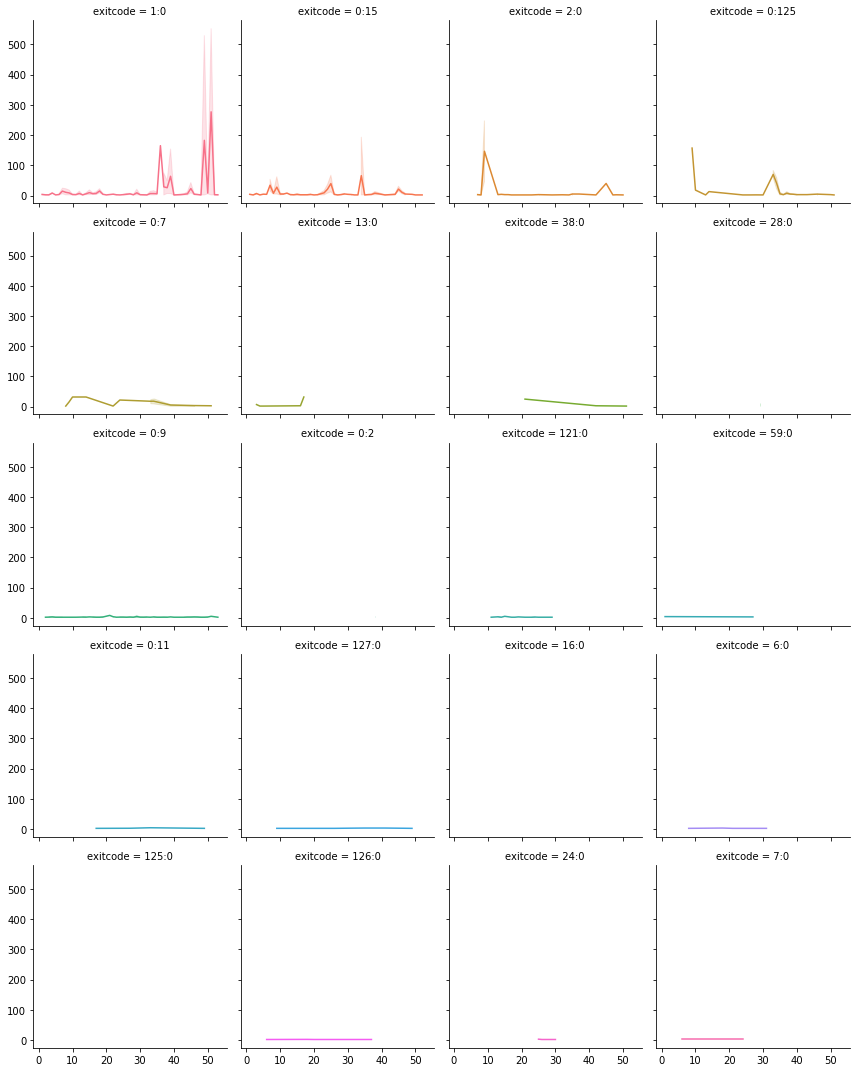

In [149]:
tmp = jobs_ended.reset_index().dropna()

g = sns.FacetGrid(tmp.query('exitcode != "0:0" and jobs_ended_per_hour > 1'),
                  col='exitcode',
                  col_wrap=4,
                  hue='exitcode')

g.map_dataframe(sns.lineplot, y='jobs_ended_per_hour', x='week_end')

The top 5 busiest months were: [ 6  3 10  9  8]
The least busiest months were: [11  5 12  1  4]


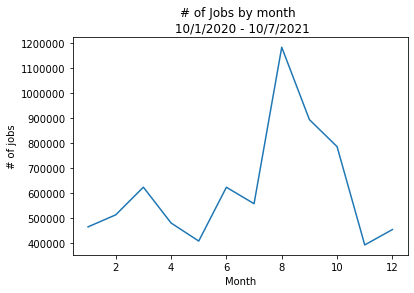

In [13]:
tmp_series = group_data(dataframe=jobs_ended, groupby='month_end', agg='jobs_ended_per_hour')

draw_plot(series=tmp_series,
          title='# of Jobs by month \n 10/1/2020 - 10/7/2021',
          xlabel='Month',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='months')

In [14]:
jobs_ended.describe()

,jobs_ended_per_hour
count,12270.000000
mean,602.708557
std,1077.217252
min,1.000000
25%,4.000000
50%,302.000000
75%,703.000000
max,13346.000000


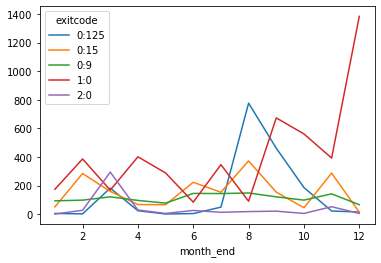

In [89]:
unsuccessful_jobs = jobs_ended.query('exitcode != "0:0"').groupby(['exitcode', 'month_end'])['jobs_ended_per_hour'].agg('sum').unstack().dropna().transpose().plot()

    #.unstack().transpose().plot()
